In [ ]:
!conda install -c anaconda swig

In [ ]:
!pip install gym "gym[box2d]" matplotlib moviepy

In [2]:
import base64, io
import numpy as np
from numpy.random import rand, seed
import glob
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 

# Reinforcement Learning

<img src="https://wikidocs.net/images/page/169311/00_Taxonomy_RL.png" width="600"/>

에이전트가 행동을 선택하고 그 행동의 보상을 통해 최적의 의사 결정을 학습하는 방법. <br> 에이전트는 주어진 환경 내에서 최적의 누적 보상을 얻기 위해 일련의 행동을 취하게 됨. <br> 강화 학습의 목표는 이러한 일련의 행동을 통해 최종적으로 최대 누적 보상을 받는 것. <br>

<br>

<font style="font-size:18px"> 종류 </font><br>

Model-Based Algorithm:
- environment의 다음 state와 reward가 어떨지에 대한 agent의 예상을 알 수 있음 <br>
- state와 action을 받아 다음 상태와 보상 예측

Model-Free Algorithm
- nvironment의 다음 state와 reward가 어떨지에 대한 agent의 예상을 모름 <br>
- action을 통해 reward의 합이 기댓값을 최대로 하는 policy function을 찾음 <br>
- 환경 파악을 위해서 exploration 진행

## Markov Decision Process

### Markov Property

미래의 상태가 현재 상태와 행동에만 의존하며, 과거의 모든 이력에는 의존하지 않음. <br>
마코프 특성에 따르면 현재 상태와 행동만으로 미래 상태와 보상을 예측 가능. <br>

$\mathbb{P}(s_{t+1}|s_{t}, a_{t}) = \mathbb{P}(s_{t+1}|s_{t}, a_{t}, ..., s_{0}, a_{0})$ <br>
$\mathbb{P}(r_{t}|s_{t}, a_{t}) = \mathbb{P}(r_{t}|s_{t}, a_{t}, ..., s_{0}, a_{0})$

#### Credit Rating

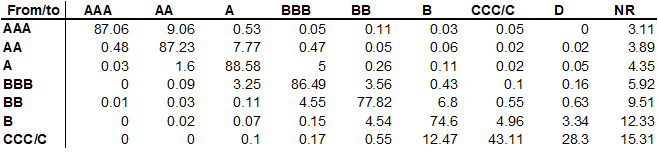

In [4]:
# seed random number generator
seed(12345)

np.set_printoptions(precision=3, suppress=True)

P0 = np.array(
    [
        [87.06, 9.06, 0.53, 0.05, 0.11, 0.03, 0.05, 0.0, 3.11],
        [0.48, 87.23, 7.77, 0.47, 0.05, 0.06, 0.02, 0.02, 3.89],
        [0.03, 1.6, 88.58, 5.0, 0.26, 0.11, 0.02, 0.05, 4.35],
        [0, 0.09, 3.25, 86.49, 3.56, 0.43, 0.1, 0.16, 5.92],
        [0.01, 0.03, 0.11, 4.55, 77.82, 6.8, 0.55, 0.63, 9.51],
        [0.0, 0.02, 0.07, 0.15, 4.54, 74.6, 4.96, 3.34, 12.33],
        [0.0, 0.0, 0.1, 0.17, 0.55, 12.47, 43.11, 28.3, 15.31],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.0, 0.0],
    ]
)

# Normalize transition matrix, ignoring NR type
P = P0[:, 0 : P0.shape[1] - 1]  # noQA E203
P = (P.T / np.sum(P, axis=1)).T

# Verify where the ratings process converges given these estimates
P10 = np.linalg.matrix_power(P, 10)
print(P10)

P40 = np.linalg.matrix_power(P, 200)
print(P40)

# SAMPLING FROM THE MARKOV CHAIN
# Simulate how long it takes a firm to default starting with some current rating
RATINGS = dict(
    [
        ("AAA", 0),
        ("AA", 1),
        ("A", 2),
        ("BBB", 3),
        ("BB", 4),
        ("B", 5),
        ("CCC", 6),
        ("D", 7),
    ]
)
CURR_RATING = "CCC"

N_HISTORIES = 1000
LEN_HIST = 100
histories = np.zeros((N_HISTORIES, LEN_HIST), np.int8)
histories[:, 0] = RATINGS[CURR_RATING]
randarray = rand(N_HISTORIES, LEN_HIST)

default_time = np.zeros(N_HISTORIES)
default_sum = 0

for i in range(0, N_HISTORIES):
    for j in range(1, LEN_HIST):
        for r in RATINGS:
            if randarray[i, j] < np.cumsum(P[histories[i, j - 1], :])[RATINGS[r]]:
                histories[i, j] = RATINGS[r]
                break
        if histories[i, j] == RATINGS["D"]:
            break
    # Compute the average time to default
    if np.max(histories[i, :]) == RATINGS["D"]:
        where_default = np.where((histories[i, :] == RATINGS["D"]))
        default_time[i] = where_default[0][0]
        default_sum += 1
    else:
        default_time[i] = 0.0

print("Default time:", np.sum(default_time) / default_sum)

[[0.353 0.387 0.192 0.046 0.011 0.006 0.001 0.005]
 [0.021 0.42  0.395 0.124 0.021 0.01  0.002 0.008]
 [0.003 0.083 0.541 0.276 0.055 0.023 0.003 0.016]
 [0.001 0.019 0.182 0.515 0.156 0.07  0.01  0.047]
 [0.    0.005 0.044 0.203 0.311 0.228 0.031 0.178]
 [0.    0.002 0.012 0.054 0.154 0.302 0.045 0.432]
 [0.    0.001 0.005 0.018 0.052 0.115 0.018 0.79 ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]]
[[0.001 0.011 0.044 0.053 0.024 0.018 0.003 0.847]
 [0.001 0.01  0.04  0.047 0.022 0.016 0.002 0.862]
 [0.001 0.009 0.035 0.042 0.019 0.014 0.002 0.878]
 [0.    0.007 0.028 0.033 0.015 0.011 0.002 0.905]
 [0.    0.004 0.016 0.019 0.009 0.007 0.001 0.945]
 [0.    0.002 0.008 0.009 0.004 0.003 0.    0.973]
 [0.    0.001 0.003 0.003 0.002 0.001 0.    0.99 ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]]
Default time: 8.28688524590164


#### Gambler

In [5]:
# seed random number generator
seed(12345)

TARGET_PURSE = 10
INIT_PURSE = 1

N_STATES = TARGET_PURSE + 1

S = np.zeros((N_STATES, 1))
P = np.zeros((N_STATES, N_STATES))

P[0, 0] = 1.0
P[N_STATES - 1, N_STATES - 1] = 1.0

for ii in range(1, N_STATES - 1):
    for jj in range(0, N_STATES):
        if jj == ii - 1 or jj == ii + 1:
            P[ii, jj] = 0.5

print("Transition matrix:\n", P)

Transition matrix:
 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.5 0.  0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.  0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.  0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.  0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


In [6]:
N_HISTORIES = 100000  # number of histories or simulations
LEN_HIST = 100  # Length of each simulation
histories = np.zeros((N_HISTORIES, LEN_HIST))
histories[:, 0] = INIT_PURSE * np.ones(N_HISTORIES)
randarray = rand(N_HISTORIES, LEN_HIST)

for i in range(0, N_HISTORIES):
    for j in range(1, LEN_HIST):
        histories[i, j] = (
            histories[i, j - 1] + (randarray[i, j] >= 0.5) - (randarray[i, j] < 0.5)
        )
        if histories[i, j] == TARGET_PURSE or histories[i, j] < 1:
            histories[i, j + 1 : LEN_HIST + 1] = histories[i, j]  # noQA E203
            break

target_num = np.sum(np.max(histories, axis=1) == TARGET_PURSE)

end_gamble = np.zeros(N_HISTORIES)
end_gamble_sum = 0

for i in range(0, N_HISTORIES):
    if np.max(histories[i, :]) == TARGET_PURSE:
        where_gamble_ends_T = np.where((histories[i, :] == TARGET_PURSE))
        end_gamble[i] = where_gamble_ends_T[0][0]
        end_gamble_sum += 1
    elif np.min(histories[i, :]) < 1:
        where_gamble_ends_0 = np.where((histories[i, :] < 1))
        end_gamble[i] = where_gamble_ends_0[0][0]
        end_gamble_sum += 1
    else:
        end_gamble[i] = 0.0

broke_num = np.sum(np.min(histories, axis=1) < 1)

print(
    "Probability of getting the target:",
    target_num / N_HISTORIES,
    "\nProbability of losing all the money:",
    broke_num / N_HISTORIES,
)
print(
    "Expected time until reaching a stopping result:",
    np.sum(end_gamble) / end_gamble_sum,
    "\nTotal number of simulations:",
    end_gamble_sum,
)

Probability of getting the target: 0.09766 
Probability of losing all the money: 0.89954
Expected time until reaching a stopping result: 8.682410750100281 
Total number of simulations: 99720


### Markov Decision Process

<img src="https://www.altexsoft.com/static/blog-post/2023/11/345fadfa-549a-462a-b757-9ab258e747f3.webp" width="400"/>

에이전트가 특정 환경에서 최적의 행동을 선택할 수 있도록 돕는 기법. <br>
각 상태에서 최선의 행동을 선택해 누적 보상을 최대화 할 수 있는 최적의 정책을 찾는 것. <br>

<br>

<font style="font-size:18px"> 용어 </font><br>
$s_t$: 시간 $t$에서의 환경 상태 <br>
$a_t$: 에이전트가 취할 수 있는 행동 <br>
$r_t$: 행동에 대한 즉각적인 보상 <br>
$s_{t+1}$: 다음 시간의 상태 <br>
$\gamma$: discount <br>

<br>

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F9971CC3A5AC84F370E" width="400"/>


## Q-Learning

<img src="https://wikidocs.net/images/page/169311/20_Q_Table.png" width="500"/>

에이전트가 환경과 상호작용하며 최적의 행동을 학습하도록 하는 기법. <br>
**Q-value** 이라는 state-action 쌍에 대한 가치를 업데이트. <br>
-> 에이전트가 각 상태에서 최적의 행동을 선택할 수 있도록 도움


### Exploration vs. Exploitation

최적 전략을 찾기 위한 방법

exploitation (활용): 지금까지 얻은 정보나 경험을 바탕으로 가장 높은 보상을 기대할 수 있는 행동을 선택하는 과정. <br>
이미 잘 알고 있는 영역에서 최상의 보상을 얻기 위해 익숙한 선택을 반복 <br>

exploration (탐색): 새로운 행동이나 선택지를 시도하여 더 많은 정보를 수집하는 과정. <br> 
이를 통해 현재는 모르는 더 나은 결과를 찾을 가능성을 확보. <br>

#### Cliff Walk

In [7]:
# The cliff walk: Comparing SARSA and Q-learning
GRID_WIDTH = 12
NROWS = 4
N = NROWS * GRID_WIDTH
A = 4

# Build an array that indicates, for each state, the destination cells
# from moving up, down, right, or left
destinations = np.zeros((N, A), dtype=np.int8)
for ss in range(0, (NROWS - 1) * GRID_WIDTH + 1):
    # determine row of position ss in the grid
    row_ss = np.floor(ss / GRID_WIDTH) + 1
    destinations[ss, 0] = (ss - GRID_WIDTH) * (ss - GRID_WIDTH >= 0) + ss * (
        ss - GRID_WIDTH < 0
    )
    destinations[ss, 1] = (ss + GRID_WIDTH) * (ss + GRID_WIDTH <= N - 1) + ss * (
        ss + GRID_WIDTH > N - 1
    )
    destinations[ss, 2] = (ss + 1) * (ss < row_ss * GRID_WIDTH - 1) + ss * (
        ss >= row_ss * GRID_WIDTH - 1
    )
    destinations[ss, 3] = (ss - 1) * (ss > (row_ss - 1) * GRID_WIDTH) + ss * (
        ss <= (row_ss - 1) * GRID_WIDTH
    )
# Destinations from falling in the cliff
destinations[(NROWS - 1) * GRID_WIDTH + 1 : NROWS * GRID_WIDTH - 1, :] = (
    NROWS - 1
) * GRID_WIDTH

print(destinations)

[[ 0 12  1  0]
 [ 1 13  2  0]
 [ 2 14  3  1]
 [ 3 15  4  2]
 [ 4 16  5  3]
 [ 5 17  6  4]
 [ 6 18  7  5]
 [ 7 19  8  6]
 [ 8 20  9  7]
 [ 9 21 10  8]
 [10 22 11  9]
 [11 23 11 10]
 [ 0 24 13 12]
 [ 1 25 14 12]
 [ 2 26 15 13]
 [ 3 27 16 14]
 [ 4 28 17 15]
 [ 5 29 18 16]
 [ 6 30 19 17]
 [ 7 31 20 18]
 [ 8 32 21 19]
 [ 9 33 22 20]
 [10 34 23 21]
 [11 35 23 22]
 [12 36 25 24]
 [13 37 26 24]
 [14 38 27 25]
 [15 39 28 26]
 [16 40 29 27]
 [17 41 30 28]
 [18 42 31 29]
 [19 43 32 30]
 [20 44 33 31]
 [21 45 34 32]
 [22 46 35 33]
 [23 47 35 34]
 [24 36 37 36]
 [36 36 36 36]
 [36 36 36 36]
 [36 36 36 36]
 [36 36 36 36]
 [36 36 36 36]
 [36 36 36 36]
 [36 36 36 36]
 [36 36 36 36]
 [36 36 36 36]
 [36 36 36 36]
 [ 0  0  0  0]]


In [8]:
def transition(state_init, action, dest, prdown, gridw, randnum):
    row_ss = np.floor(state_init / gridw)
    if randnum < prdown[int(row_ss)]:
        state_end = dest[int(state_init), 1]
    else:
        state_end = dest[int(state_init), action]
    return state_end


def exploring_starts(nstates, randnum):
    for ss in range(nstates):
        if randnum < (ss + 1) / nstates:
            break
    return ss


def e_greedy_policy(nactions, pol, eps, randnum1, randnum2, randnum3):
    if randnum1 < eps:
        for aa in range(nactions):
            if randnum2 < (aa + 1) / A:
                break
    else:
        for aa in range(nactions):
            if randnum3 < np.cumsum(pol)[aa]:
                break
    return aa

In [9]:
# Q-Learning method in cliff walk

seed(1234)

# Assume an initial policy that is random
policy = np.ones((N, A)) / A
qvalue = np.zeros((N, A))

# Array to fill with optimal action at each cell
policy0 = np.zeros((N))

EPISODES = 2000
EPISODE_TMAX = 500
EPSILON = 0.1
ALPHA = 0.1

for episode in range(EPISODES):
    # Choose initial state
    ss0 = exploring_starts(N, rand())
    # Use policy to generate history
    for tt in range(EPISODE_TMAX):
        qvalue_old = qvalue.copy()
        if ss0 > N - 2:
            break
        # e-greedy policy to choose a
        aa = e_greedy_policy(A, policy[int(ss0), :], EPSILON, rand(), rand(), rand())
        # Determine S' given (S,A)
        ss1 = destinations[int(ss0), aa]
        if ss1 < N - 1:
            qvalue[ss0, aa] = qvalue_old[ss0, aa] + ALPHA * (
                -1 * (ss1 <= (NROWS - 1) * GRID_WIDTH)
                - 100 * (ss1 > (NROWS - 1) * GRID_WIDTH)
                + np.max(qvalue_old[ss1, :])
                - qvalue_old[ss0, aa]
            )
        else:
            qvalue[ss0, aa] = qvalue_old[ss0, aa] + ALPHA * (-1 - qvalue_old[ss0, aa])
        # Improve policy
        policy0[ss0] = np.argmax(qvalue[ss0, :])
        policy[ss0, :] = np.zeros((A))
        policy[ss0, int(policy0[ss0])] = 1.0
        ss0 = ss1

# Optimal policy at each cell
for rr in range(NROWS):
    print(policy0[rr * GRID_WIDTH : rr * GRID_WIDTH + GRID_WIDTH])

[2. 2. 2. 2. 1. 2. 1. 2. 1. 2. 2. 1.]
[2. 2. 2. 2. 1. 2. 1. 2. 2. 1. 1. 1.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1.]
[0. 2. 0. 3. 0. 2. 0. 2. 2. 2. 1. 0.]


In [10]:
policy

array([[0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.

## Policy Gradient Learning

<img src="https://wikidocs.net/images/page/172862/Fig_4_6.png" width="700"/>

Policy Gradient 방식으로 Q-learning의 한계점을 보완한 학습 방법. <br>
다르게 신경망을 이용하여 Softmax Regression 방식으로 action들의 확률을 구하고 분포를 얻어 학습하는 방식.

In [3]:
env = gym.make('LunarLander-v2')
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


In [4]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [5]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

In [6]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network
device = 'cpu'

In [7]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [17]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        if isinstance(state, tuple):   # check if state is a tuple
            state = state[0]           # extract first element if it is a tuple
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            # Unpack only the required variables (next_state, reward, done)
            step_result = env.step(action)
            if len(step_result) == 3:
                next_state, reward, done = step_result
            else:
                next_state, reward, done, *_ = step_result
            if isinstance(next_state, tuple):
                next_state = next_state[0]  # extract first element if next_state is a tuple
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores


agent = Agent(state_size=8, action_size=4, seed=0)
scores = dqn()

C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100	Average Score: -174.88
Episode 200	Average Score: -134.91
Episode 300	Average Score: -61.114
Episode 400	Average Score: -18.87
Episode 500	Average Score: 95.377
Episode 600	Average Score: 104.36
Episode 700	Average Score: 109.25
Episode 800	Average Score: 189.04
Episode 821	Average Score: 200.08
Environment solved in 721 episodes!	Average Score: 200.08


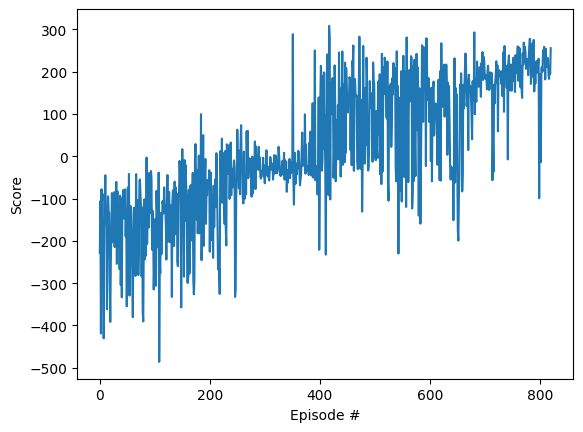

In [18]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [30]:
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
        
def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    state, *_ = env.reset()
    done = False
    while not done:
        frame = env.render()
        vid.capture_frame()  # 프레임 캡처
        
        action = agent.act(state)
        state, reward, done, *_ = env.step(action)

    env.close()

In [35]:
agent = Agent(state_size=8, action_size=4, seed=0)
show_video_of_model(agent, 'LunarLander-v2')

C:\Users\USER\AppData\Local\Temp\ipykernel_48368\546709118.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.qnetwork_local.load_state_dict(torch.load('checkpoint.p

Moviepy - Building video video/LunarLander-v2.mp4.
Moviepy - Writing video video/LunarLander-v2.mp4



Moviepy - Done !
Moviepy - video ready video/LunarLander-v2.mp4


In [36]:
show_video('LunarLander-v2')

## Proximal Policy Optimization

<img src="https://www.researchgate.net/publication/366247043/figure/fig1/AS:11431281107244964@1670987438222/High-level-diagram-of-the-proximal-policy-optimization-algorithm.png" width="700"/>

Policy Gradient의 문제점을 보완한 방법. <br>

<br>

<font style="font-size:18px"> Policy Gradient의 단점 </font>
- gradient 이용으로 경사가 급격한 경우 상반된 결과가 반복될 수 있어 불안정 학습 (learning rate가 클 때와 비슷한 효과)
- 경사가 완만한 경우 학습 속도가 매우 느림 (learning rate가 작을 때와 비슷한 효과)
- episode 단위로 결과가 반영되어, 한 step내에서 학습된 결과가 반영되지 않은 채 episode가 진행

<br>

<font style="font-size:18px"> 제안 방법 </font>

- 학습 데이터 재사용 <br>
    - episode 단위로 반영하는 것이아닌 step 단위로 데이터 학습 <br>
    -> agent가 보다 빠르게 정책 업데이트 가능
- importance sampling
    - 값을 보정하여 상하한선을 만듦 (기존 정책에 대한 새로운 정책의 비율) <br>
    -> 업데이트가 너무 커지지 않도록 함
- actor/critic 신경망
    - actor: 정책 업데이트
    - critic: 가치 함수 업데이트, actor의 보상을 최대화 할 수 있도록 방향 제시